In [23]:
# import sys
# sys.path.append('../Scripts')
# from PostProcessingScripts import * 
# import pandas as pd 
# import string 
# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt


In [41]:
class COMPASData(object):
    """ this class reads in datafile & gives you M1 and M2 and some other things """

    def __init__(self, path=None, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1):
        self.path                = path
        if (self.path is None):
            print("Just to double check you create instance of ClassCOMPAS without path/Data")
        elif not  os.path.isfile(path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%path)
        elif os.path.isfile(path):
            self.h5file           = h5.File(path)
        # old code with fixed COMPAS h5 filename:
        #
        # elif not  os.path.isfile(path+'COMPASOutput.h5'):
        #     raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%path)
        # elif os.path.isfile(path+'COMPASOutput.h5'):
        #     self.h5file           = h5.File(path+'COMPASOutput.h5')



        #Crucial values to be able to calculate MSSFR
        self.metallicityGrid     = None
        self.metallicitySystems  = None
        self.delayTimes          = None
        #Crucial values I need for selection effects
        self.mass1               = None
        self.mass2               = None

        self.m1zams               = None
        self.m2zams               = None
        self.separationzams       = None

        self.weight              = None  # //floor
        self.DCOmask             = None

        #Additional arrays that might be nice to store
        #to more quickly make some plots.
        #If you need more memory might help a tiny bit to not do
        self.lazyData            = lazyData
        self.pessimictic_allDCO  = None  #which of all DCO are pessimistic
        self.pessimictic_subSet  = None  #which of the systems calculated are pessimistic
        self.mChirp              = None
        self.q                   = None
        self.eccentricityDCOFormation = None
        self.separationDCOFormation =None
        self.tc                  = None
        self.seeds               = None
        self.systemicVelocity    = None

        self.Mlower              = Mlower
        self.Mupper              = Mupper
        self.binaryFraction      = binaryFraction
        self.totalMassEvolvedPerZ = None
        
#         if self.path is not None:
#            self.setGridAndMassEvolved()        

#         print("Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()")

    
    def setCOMPASDCOmask(self, types='BBH', withinHubbleTime=True, optimistic=False):
            #We do not want all the formation channels just the ones that form BBHs
            fDCO    = self.h5file['doubleCompactObjects']
            if types == 'BBH':
                maskTypes = (fDCO['stellarType1'][...].squeeze() == 14) &\
                            (fDCO['stellarType2'][...].squeeze() == 14)
            elif types == 'BNS':
                maskTypes = (fDCO['stellarType1'][...].squeeze() == 13) &\
                            (fDCO['stellarType2'][...].squeeze() == 13)
            elif types == 'BHNS':
                maskTypes = ((fDCO['stellarType1'][...].squeeze() == 14) &\
                            (fDCO['stellarType2'][...].squeeze() == 13)) |\
                            ((fDCO['stellarType1'][...].squeeze() == 13) &\
                            (fDCO['stellarType2'][...].squeeze() == 14))
            elif types == 'ALL':
                maskTypes = ((fDCO['stellarType1'][...].squeeze() == 14) |\
                            (fDCO['stellarType1'][...].squeeze() == 13)) &\
                            ((fDCO['stellarType2'][...].squeeze() == 13) |\
                            (fDCO['stellarType2'][...].squeeze() == 14))
            else:
                raise ValueError('types=%s not in BBH, BNS, BHNS' %(types))         
            if withinHubbleTime == True:
                maskHubble = (fDCO['mergesInHubbleTimeFlag'][...].squeeze()==True)
            else:
                #Array where all are true
                maskHubble = np.ones(len(fDCO['mergesInHubbleTimeFlag'][...].squeeze()), dtype=bool)
                              
            if optimistic == True:
                #we do not care about the optimistic flag (both False and True allowed)
                #Array where all are true
                maskOptimistic = np.ones(len(fDCO['optimisticCEFlag'][...].squeeze()), dtype=bool)
            else:
                #optimistic scenario not allowed (pessimistic) hence the flag must be false
                #This removes systems with CEE from HG donors (no core envelope separation)
                maskOptimistic = fDCO['optimisticCEFlag'][...].squeeze() == False
                              
            #we never want in first timestep after CEE, because 
            #we define it as a system that should not have survived the CEE
            maskNoRLOFafterCEE =  (fDCO['RLOFSecondaryAfterCEE'][...].squeeze()==False)
                              

            self.DCOmask = maskTypes & maskHubble & maskOptimistic & maskNoRLOFafterCEE

#     def setGridAndMassEvolved(self):
    
#         #The COMPAS simulation does not evolve all stars 
#         #give me the correction factor for the total mass evolved
#         #I assume each metallicity has the same limits, and does correction
#         #factor, but the total mass evolved might be different.
#         #This does not change when we change types and other masks this is 
#         #general to the entire simulation so calculate once
#         _, self.totalMassEvolvedPerZ =\
#         MPZ.totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
#                                  Mupper=self.Mupper, binaryFraction=self.binaryFraction)
#         #Want to recover entire metallicity grid, assume that every metallicity
#         #evolved shows in all systems again should not change within same run
#         #so dont redo if we reset the data
#         metallicities = self.h5file['systems']['Metallicity1'][...].squeeze()
#         self.metallicityGrid     = np.unique(metallicities)


    def setCOMPASData(self):
        fDCO      = self.h5file['doubleCompactObjects']
        #Stuff I need for cosmological integral
        

        #sorry not the prettiest line is a boolean slice of seeds
        #this only works because seeds in systems file and DCO file are printed
        #in same order

        #TODO more elegant slicing not unpack all and then mask 
        #something like f[M1][mask][...] but the the way I setup DCO mask needs different shape
        #metallicities = metallicities[np.in1d(self.h5file['systems']['SEED'][...].squeeze(),\
        #                        fDCO['seed'][...].squeeze()[self.DCOmask])]
        
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze()[self.DCOmask]
        self.delayTimes          = fDCO['tform'][...].squeeze()[self.DCOmask] + \
                                   fDCO['tc'][...].squeeze()[self.DCOmask]
        self.tc                  = fDCO['tc'][...].squeeze()[self.DCOmask]
        self.mass1               = fDCO['M1'][...].squeeze()[self.DCOmask]
        self.mass2               = fDCO['M2'][...].squeeze()[self.DCOmask]
        self.weight              = fDCO['weight'][...].squeeze()[self.DCOmask] # //floor
        self.m1zams              = fDCO['M1ZAMS'][...].squeeze()[self.DCOmask]
        self.m2zams              = fDCO['M2ZAMS'][...].squeeze()[self.DCOmask]
        self.separationzams      = fDCO['separationInitial'][...].squeeze()[self.DCOmask]


        

        

        #Stuff of data I dont need for integral
        #but I might be to laze to read in myself
        #and often use. Might turn it of for memory efficiency
        if self.lazyData:
            self.pessimictic_allDCO  = fDCO['optimisticCEFlag'][...].squeeze()==False
            self.pessimictic_subSet  = fDCO['optimisticCEFlag'][...].squeeze()[self.DCOmask]==False
            self.q                   = np.divide(self.mass2, self.mass1)
            boolq                    = self.mass2 > self.mass1
            self.q[boolq]            = np.divide(self.mass1[boolq], self.mass2[boolq])
            self.mChirp = np.divide((np.multiply(self.mass2, self.mass1)**(3./5.) ),\
                                           (np.add(self.mass2, self.mass1)**(1./5.)))

            self.separationDCOFormation= fDCO['separationDCOFormation'][...].squeeze()[self.DCOmask]
            self.eccentricityDCOFormation= fDCO['eccentricityDCOFormation'][...].squeeze()[self.DCOmask]
            self.seeds               = fDCO['seed'][...].squeeze()[self.DCOmask]
            self.Hubble              = fDCO['mergesInHubbleTimeFlag'][...].squeeze()[self.DCOmask]

            fSN     = self.h5file['supernovae']
            seedsSN = fSN ['randomSeed'][...].squeeze()
            bools = np.in1d(seedsSN, self.seeds)
            self.systemicVelocity    = fSN['systemicVelocity'][...].squeeze()[bools]


#     def setGridAndMassEvolved(self):

#         #The COMPAS simulation does not evolve all stars 
#         #give me the correction factor for the total mass evolved
#         #I assume each metallicity has the same limits, and does correction
#         #factor, but the total mass evolved might be different.
#         #This does not change when we change types and other masks this is 
#         #general to the entire simulation so calculate once
#         _, self.totalMassEvolvedPerZ =\
#         MPZ.totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
#                                  Mupper=self.Mupper, binaryFraction=self.binaryFraction)
#         #Want to recover entire metallicity grid, assume that every metallicity
#         #evolved shows in all systems again should not change within same run
#         #so dont redo if we reset the data
#         metallicities = self.h5file['systems']['Metallicity1'][...].squeeze()
#         self.metallicityGrid     = np.unique(metallicities)


In [3]:

# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/COMPASOutput.h5' # change this line! 



fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())





<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems']>


# 3 "The Big file" with all the data points: Note that my data is weighted!

all lines of code that you might have to change are given with "# change this line! " 

In [18]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BHNS'   # You can change this line to 'BBH', 'BHNS' 'NSNS', or 'ALL' (All DCOs)  # change this line! 

print('this might take a little while, particularly if you are using the BBH')

# This code below gets the COMPAS data and only the systems that are DCOs 
Data            = COMPASData(path=path, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1)
Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
# SeedsHubble    = Data.seeds[Data.Hubble==True]











this might take a little while, particularly if you are using the BBH


### M1, M2 and Chirpmass in Msun

not that these parameters are the properties for the selected DCOtype 

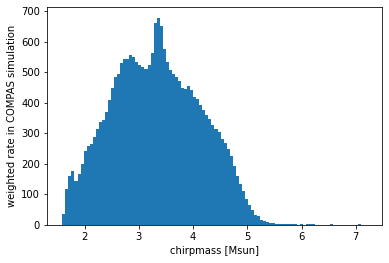

this distribution is not yet SFRD(Z,z) and detector weighted


In [38]:
# to obtain the properties of the selected DCOtype you simply do this:
M1 = Data.mass1
M2 = Data.mass2
weights = Data.weight


def chirpmass(m1, m2):
    numer = (m1*m2)**(3./5)
    denom = (m1+m2)**(1./5)
    
    return numer/denom

# and you can plot properties, e.g., the chirpmass distribution: 
chirpmass =chirpmass(m1=M1, m2=M2)


plt.hist(chirpmass, bins=100, weights=weights)
plt.xlabel('chirpmass [Msun]')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()

print('this distribution is not yet SFRD(Z,z) and detector weighted')


### M1 more massive, M2 least massive:






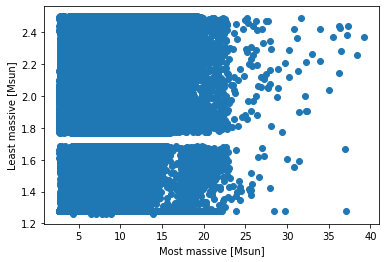

In [40]:
def obtainM1BHandM2BHassymetric(m1, m2):
    m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = ( m1 >= m2)
    maskm2heavier = (m1 < m2)
    
    m1bh[maskm1heavier] = m1[maskm1heavier] 
    m1bh[maskm2heavier] = m2[maskm2heavier]
    m2bh[maskm1heavier] = m2[maskm1heavier]
    m2bh[maskm2heavier] = m1[maskm2heavier]
    
    return m1bh, m2bh # m1bh has all the heaviest systems



M_most_massive, M_least_massive = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)


plt.scatter(M_most_massive, M_least_massive)
plt.xlabel('Most massive [Msun]')
plt.ylabel('Least massive [Msun]')
plt.show()



### Metallicity 

the metallicity of each data point can be obtained with "metallicitySystems"
I used a total of 53 different metallicity bins, quoted in the bottem when printing "Data.metallicityGrid" 

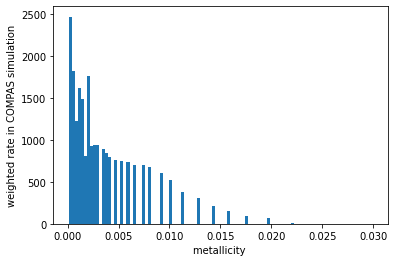

[0.0001  0.00011 0.00012 0.00014 0.00016 0.00017 0.00019 0.00022 0.00024
 0.00027 0.0003  0.00034 0.00037 0.00042 0.00047 0.00052 0.00058 0.00065
 0.00073 0.00081 0.0009  0.00101 0.00113 0.00126 0.0014  0.00157 0.00175
 0.00195 0.00218 0.00243 0.00272 0.00303 0.00339 0.00378 0.00422 0.00471
 0.00526 0.00587 0.00655 0.00732 0.00817 0.00912 0.01018 0.01137 0.01269
 0.01416 0.01581 0.01765 0.01971 0.022   0.0244  0.02705 0.03   ]
53


In [34]:
metallicitySystems = Data.metallicitySystems
plt.hist(metallicitySystems, bins=100, weights=weights)
plt.xlabel('metallicity ')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()


Data.metallicityGrid = np.unique(metallicitySystems)
print(Data.metallicityGrid)
print(len(Data.metallicityGrid))




### Delay time  of each simulated data point in Myr

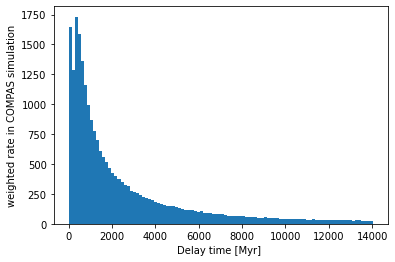

In [37]:
delayTimes = Data.delayTimes


plt.hist(delayTimes, bins=100, weights=weights)
plt.xlabel('Delay time [Myr] ')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()




In [52]:
import string

In [66]:
print(df['Zi'])

0     0.00010
1     0.00011
2     0.00012
3     0.00014
4     0.00016
5     0.00017
6     0.00019
7     0.00022
8     0.00024
9     0.00027
10    0.00030
11    0.00034
12    0.00037
13    0.00042
14    0.00047
15    0.00052
16    0.00058
17    0.00065
18    0.00073
19    0.00081
20    0.00090
21    0.00101
22    0.00113
23    0.00126
24    0.00140
25    0.00157
26    0.00175
27    0.00195
28    0.00218
29    0.00243
30    0.00272
31    0.00303
32    0.00339
33    0.00378
34    0.00422
35    0.00471
36    0.00526
37    0.00587
38    0.00655
39    0.00732
40    0.00817
41    0.00912
42    0.01018
43    0.01137
44    0.01269
45    0.01416
46    0.01581
47    0.01765
48    0.01971
49    0.02200
50    0.02440
51    0.02705
52    0.03000
Name: Zi, dtype: float64


# 1. formation efficiency file: 

In [46]:
import pandas as pd 

pathCSVfile='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_1/'

pathWriteTo = '/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/Martyna_SFRD/1_formation_efficiency'


df = pd.read_csv(pathCSVfile + 'formationRatesTotalAndPerChannel_'+DCOname+ '_' +  '.csv', index_col=0)

for ind_m, bps_model in enumerate(BPSnameslist):
    for DCOname in ['BHBH', 'BHNS', 'NSNS']:
    
        df = pd.read_csv(pathCSVfile + 'formationRatesTotalAndPerChannel_'+DCOname+ '_' +  '.csv', index_col=0)
    
        c_ = 'total'
        key_ =  bps_model + ' ' + c_ + '  [Msun^{-1}]'

        # rate of this channel: 
        upperY = np.asarray(df[key_])

    
    
    
print(df)

         A total  [Msun^{-1}]  A I_classic  [Msun^{-1}]  \
Z_i                                                       
0_0001           4.520192e-05              2.069707e-05   
0_00011          4.633445e-05              2.251433e-05   
0_00012          4.696560e-05              2.312219e-05   
0_00014          4.734547e-05              2.328459e-05   
0_00016          4.755733e-05              2.428509e-05   
0_00017          4.750986e-05              2.488252e-05   
0_00019          4.851627e-05              2.714278e-05   
0_00022          4.788043e-05              2.768273e-05   
0_00024          4.876057e-05              2.812950e-05   
0_00027          4.911843e-05              2.845220e-05   
0_0003           4.955859e-05              2.878059e-05   
0_00034          5.037767e-05              2.945469e-05   
0_00037          5.038026e-05              2.938104e-05   
0_00042          5.103750e-05              2.969780e-05   
0_00047          5.077655e-05              2.983283e-05 